In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2 
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

2024-05-29 22:54:54.430325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 22:54:54.430421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 22:54:54.569462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
np.random.seed(42)

In [4]:
#Convolution Block
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

#Encoder Block
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Encoder Block
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#main function for u-net model
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,3))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

In [5]:
#Dice coefficient
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

#Dice Loss
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [6]:
H = 256 #Height
W = 256 #Width

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("csv") #Folder for csv files

In [7]:
#Dataset: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

#DataLoader
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "./data/images", "*.png")))
    masks = sorted(glob(os.path.join(path, "./data/masks", "*.png")))
    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


In [ ]:
#Read Images
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

#Read Masks
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
    x = cv2.resize(x, (W, H))   
    x = x / 255.0               
    x = x.astype(np.float32)    
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
#Parse Images
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

#Create TF dataset
def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
batch_size = 32
lr = 1e-4
num_epochs = 100
model_path = os.path.join("./", "model.h5")
csv_path = os.path.join("./csv", "log.csv")
dataset_path="./data"

In [11]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path) #Load raw dataset

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [12]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size) #Load TF train data
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size) #Load TF val data

In [13]:
model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [14]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True), #Callback for saving best weights
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1), #Callback for reducing lr rate
        CSVLogger(csv_path), #CSV logger
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False) #Earlystopping if val_loss did not decrease in last 20 epochs
    ]

In [15]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=1,
    )

Epoch 1/100


I0000 00:00:1717023401.083172     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58/58 [==============================] - ETA: 0s - loss: 0.8750 - dice_coef: 0.1261 - accuracy: 0.8467
Epoch 1: val_loss improved from inf to 0.96950, saving model to /kaggle/working/files/model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 127s 1s/step - loss: 0.8750 - dice_coef: 0.1261 - accuracy: 0.8467 - val_loss: 0.9695 - val_dice_coef: 0.0304 - val_accuracy: 0.9714 - lr: 1.0000e-04
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 0.7225 - dice_coef: 0.2784 - accuracy: 0.9736
Epoch 2: val_loss did not improve from 0.96950
58/58 [==============================] - 49s 848ms/step - loss: 0.7225 - dice_coef: 0.2784 - accuracy: 0.9736 - val_loss: 0.9848 - val_dice_coef: 0.0151 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 3/100
58/58 [==============================] - ETA: 0s - loss: 0.6499 - dice_coef: 0.3508 - accuracy: 0.9823
Epoch 3: val_loss did not improve from 0.96950
58/58 [==============================] - 49s 843ms/step - loss: 0.6499 - dice_coef: 0.3508 - accuracy: 0.9823 - val_loss: 0.9931 - val_dice_coef: 0.0068 - val_accuracy: 0.6992 - lr: 1.0000e-04
Epoch 4/100
58/58 [==============================] - ETA: 0s - loss: 0.5966 - dice_coef: 0.4041 - a

In [17]:
import pandas as pd
metrics = pd.read_csv("/kaggle/working/files/log.csv")
metrics.head(91)

,epoch,accuracy,dice_coef,loss,lr,val_accuracy,val_dice_coef,val_loss
0,0,0.846743,0.126131,0.875007,1.000000e-04,0.971443,0.030385,0.969496
1,1,0.973559,0.278389,0.722498,1.000000e-04,0.774964,0.015133,0.984837
2,2,0.982333,0.350797,0.649886,1.000000e-04,0.699191,0.006824,0.993139
3,3,0.985048,0.404104,0.596649,1.000000e-04,0.872355,0.006298,0.993677
4,4,0.987351,0.459004,0.541792,1.000000e-04,0.863214,0.010405,0.989337
...,...,...,...,...,...,...,...,...
86,86,0.998366,0.857570,0.142561,1.000000e-07,0.993083,0.696134,0.295787
87,87,0.998367,0.857627,0.142504,1.000000e-07,0.993083,0.696133,0.295783
88,88,0.998368,0.857681,0.142450,1.000000e-07,0.993082,0.696119,0.295792
89,89,0.998369,0.857735,0.142396,1.000000e-07,0.993082,0.696100,0.295807


<Axes: >

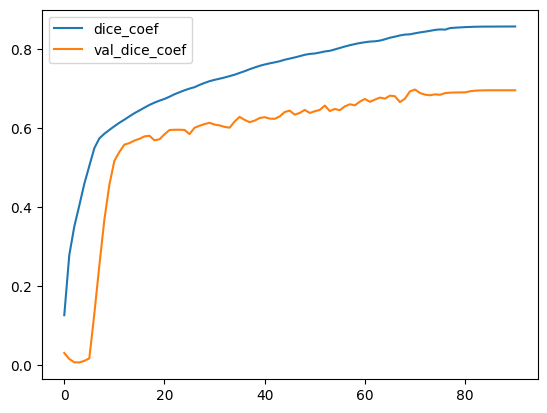

In [18]:
metrics[['dice_coef','val_dice_coef']].plot()

<Axes: >

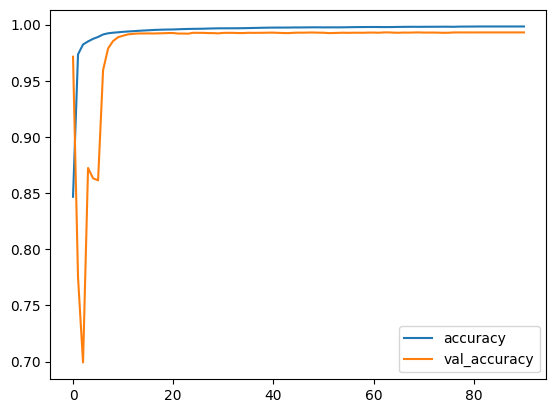

In [19]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

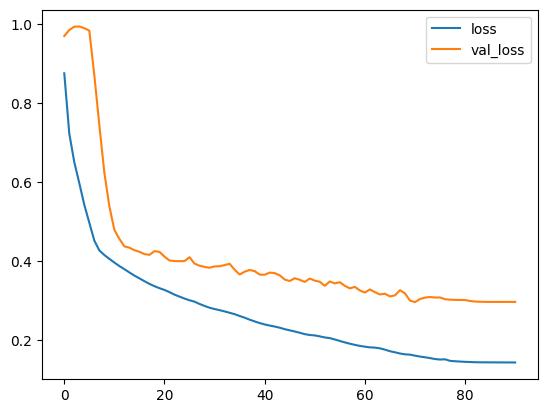

In [20]:
metrics[['loss','val_loss']].plot()

In [21]:
create_dir("./results")

In [22]:
#Save prediction results
from tqdm import tqdm
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [23]:
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    #Extracting the name
    name = x.split("/")[-1]

    #Reading the image
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    #Reading the mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    #Prediction
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    #Saving the prediction
    save_image_path = os.path.join("./results", name)
    save_results(image, mask, y_pred, save_image_path)

    #Flatten the array
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    #Calculating the metrics values
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

#Metrics values
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv", index=None)

100%|██████████| 612/612 [02:02<00:00,  5.00it/s]


F1: 0.72388
Jaccard: 0.63052
Recall: 0.71059
Precision: 0.80738


In [24]:
scores = pd.read_csv("/kaggle/working/files/score.csv")
scores.head()

,Image,F1,Jaccard,Recall,Precision
0,833.png,0.942675,0.891566,0.911972,0.975518
1,2069.png,0.891137,0.803649,0.984043,0.814261
2,3038.png,0.705882,0.545455,0.719626,0.692654
3,1169.png,0.942516,0.891281,0.892241,0.998794
4,501.png,0.943455,0.892962,0.896907,0.995098


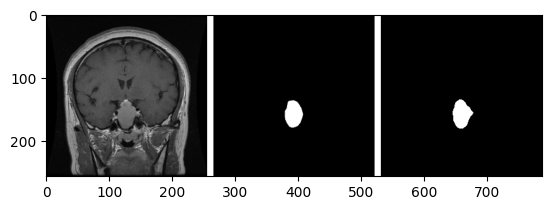

In [25]:
dir = "./results/"
images = os.listdir("./results/")[:5]
img1 = plt.imread(dir+images[0])
plt.imshow(img1, cmap='gray')

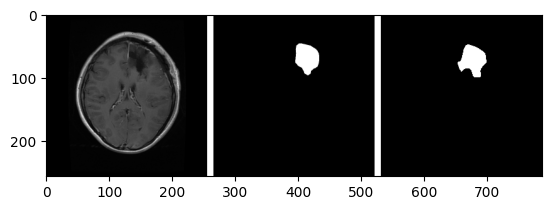

In [26]:
img1 = plt.imread(dir+images[1])
plt.imshow(img1, cmap='gray')

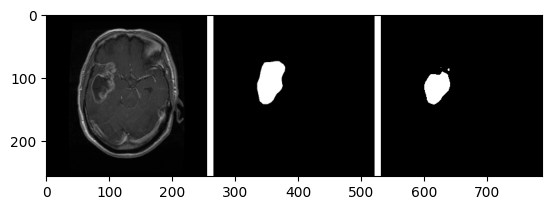

In [27]:
img1 = plt.imread(dir+images[3])
plt.imshow(img1, cmap='gray')